### Multi-Class Model for Kaggle Tabular Playground Series May 2021 Using Python and Scikit-Learn
### David Lowe
### July 7, 2021

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: This project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The Kaggle Tabular Playground Apr 2021 dataset is a multi-class modeling situation where we attempt to predict one of several (more than two) possible outcomes.

INTRODUCTION: Kaggle wants to provide an approachable environment for relatively new people in their data science journey. Since January 2021, they have hosted playground-style competitions on Kaggle with fun but less complex, tabular datasets. The dataset used for this competition is synthetic but based on a real dataset and generated using a CTGAN. The original dataset deals with predicting the category on an eCommerce product given various attributes about the listing. Although the features are anonymized, they have properties relating to real-world features.

ANALYSIS: The average performance of the machine learning algorithms achieved a logarithmic loss benchmark of 5.7866 using the training dataset. We selected Logistic Regression and Random Forest to perform the tuning exercises. After a series of tuning trials, the refined Logistic Regression model processed the training dataset with a final logarithmic loss score of 1.0918. When we processed Kaggle's test dataset with the final model, the model achieved a logarithmic loss score of 1.0916.

CONCLUSION: In this iteration, the Logistic Regression model appeared to be a suitable algorithm for modeling this dataset.

Dataset Used: Kaggle Tabular Playground 2021 May Data Set

Dataset ML Model: Multi-Class classification with numerical and categorical attributes

Dataset Reference: https://www.kaggle.com/c/tabular-playground-series-may-2021/

One potential source of performance benchmark: https://www.kaggle.com/c/tabular-playground-series-may-2021/leaderboard

Any predictive modeling machine learning project generally can be broken down into about six major tasks:

1. Prepare Environment
2. Summarize and Visualize Data
3. Pre-process Data
4. Train and Evaluate Models
5. Fine-tune and Improve Models
6. Finalize Model and Present Analysis

## Task 1 - Prepare Environment

In [1]:
# Install the necessary packages for Colab
# !pip install python-dotenv PyMySQL

In [2]:
# Retrieve the GPU information from Colab
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#     print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
#     print('and then re-execute this cell.')
# else:
#     print(gpu_info)

In [3]:
# Retrieve the memory configuration from Colab
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

# if ram_gb < 20:
#     print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
#     print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
#     print('re-execute this cell.')
# else:
#     print('You are using a high-RAM runtime!')

In [4]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 6


### 1.a) Load libraries and modules

In [5]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import math
from datetime import datetime
# import boto3
# from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

### 1.b) Set up the controlling parameters and functions

In [7]:
# Begin the timer for the script processing
start_time_script = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 2

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.2
VAL_SET_RATIO = 0.25

# Set the number of folds for cross validation
N_FOLDS = 5

# Set various default modeling parameters
SCORING_METRIC = 'neg_log_loss'

In [8]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [9]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [10]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021may/train.csv'
df_dataset_import = pd.read_csv(dataset_path, index_col=False)

# Take a peek at the dataframe after import
print(df_dataset_import.head())

   id  feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0   0          0          0          1          0          1          0   
1   1          0          0          0          0          2          1   
2   2          0          0          0          0          0          0   
3   3          0          0          0          0          0          0   
4   4          0          0          0          0          0          0   

   feature_6  feature_7  feature_8  ...  feature_41  feature_42  feature_43  \
0          0          0          0  ...           0           0          21   
1          0          0          0  ...           0           0           0   
2          0          0          0  ...           0           1           0   
3          0          3          0  ...           0           0           0   
4          0          0          0  ...           0           0           0   

   feature_44  feature_45  feature_46  feature_47  feature_48  feature_49 

In [11]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 52 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id          100000 non-null  int64 
 1   feature_0   100000 non-null  int64 
 2   feature_1   100000 non-null  int64 
 3   feature_2   100000 non-null  int64 
 4   feature_3   100000 non-null  int64 
 5   feature_4   100000 non-null  int64 
 6   feature_5   100000 non-null  int64 
 7   feature_6   100000 non-null  int64 
 8   feature_7   100000 non-null  int64 
 9   feature_8   100000 non-null  int64 
 10  feature_9   100000 non-null  int64 
 11  feature_10  100000 non-null  int64 
 12  feature_11  100000 non-null  int64 
 13  feature_12  100000 non-null  int64 
 14  feature_13  100000 non-null  int64 
 15  feature_14  100000 non-null  int64 
 16  feature_15  100000 non-null  int64 
 17  feature_16  100000 non-null  int64 
 18  feature_17  100000 non-null  int64 
 19  feature_18  100000 non-n

In [12]:
print(df_dataset_import.describe())

                  id      feature_0      feature_1      feature_2  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean    49999.500000       0.257830       0.431720       0.114130   
std     28867.657797       0.929033       1.977862       0.519584   
min         0.000000       0.000000       0.000000       0.000000   
25%     24999.750000       0.000000       0.000000       0.000000   
50%     49999.500000       0.000000       0.000000       0.000000   
75%     74999.250000       0.000000       0.000000       0.000000   
max     99999.000000      10.000000      31.000000       6.000000   

           feature_3      feature_4      feature_5      feature_6  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean        0.590550       0.599770       0.160820       0.731490   
std         1.844558       2.785531       0.601149       2.343465   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.0000

In [13]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

id            0
feature_0     0
feature_1     0
feature_2     0
feature_3     0
feature_4     0
feature_5     0
feature_6     0
feature_7     0
feature_8     0
feature_9     0
feature_10    0
feature_11    0
feature_12    0
feature_13    0
feature_14    0
feature_15    0
feature_16    0
feature_17    0
feature_18    0
feature_19    0
feature_20    0
feature_21    0
feature_22    0
feature_23    0
feature_24    0
feature_25    0
feature_26    0
feature_27    0
feature_28    0
feature_29    0
feature_30    0
feature_31    0
feature_32    0
feature_33    0
feature_34    0
feature_35    0
feature_36    0
feature_37    0
feature_38    0
feature_39    0
feature_40    0
feature_41    0
feature_42    0
feature_43    0
feature_44    0
feature_45    0
feature_46    0
feature_47    0
feature_48    0
feature_49    0
target        0
dtype: int64
Total number of NaN in the dataframe:  0


### 1.d) Data Cleaning

In [14]:
# Dropping features
df_dataset_import.drop(columns=['id'], inplace=True)

# Convert columns from one data type to another
train_feature_list = list(df_dataset_import.columns)
for feature in train_feature_list:
    df_dataset_import[feature] = df_dataset_import[feature].astype('category')

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head())

  feature_0 feature_1 feature_2 feature_3 feature_4 feature_5 feature_6  \
0         0         0         1         0         1         0         0   
1         0         0         0         0         2         1         0   
2         0         0         0         0         0         0         0   
3         0         0         0         0         0         0         0   
4         0         0         0         0         0         0         0   

  feature_7 feature_8 feature_9  ... feature_41 feature_42 feature_43  \
0         0         0         0  ...          0          0         21   
1         0         0         0  ...          0          0          0   
2         0         0         2  ...          0          1          0   
3         3         0         0  ...          0          0          0   
4         0         0         0  ...          0          0          0   

  feature_44 feature_45 feature_46 feature_47 feature_48 feature_49   target  
0          0          0        

In [15]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 51 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   feature_0   100000 non-null  category
 1   feature_1   100000 non-null  category
 2   feature_2   100000 non-null  category
 3   feature_3   100000 non-null  category
 4   feature_4   100000 non-null  category
 5   feature_5   100000 non-null  category
 6   feature_6   100000 non-null  category
 7   feature_7   100000 non-null  category
 8   feature_8   100000 non-null  category
 9   feature_9   100000 non-null  category
 10  feature_10  100000 non-null  category
 11  feature_11  100000 non-null  category
 12  feature_12  100000 non-null  category
 13  feature_13  100000 non-null  category
 14  feature_14  100000 non-null  category
 15  feature_15  100000 non-null  category
 16  feature_16  100000 non-null  category
 17  feature_17  100000 non-null  category
 18  feature_18  100000 non-nu

In [16]:
print(df_dataset_import.describe())

        feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
count      100000     100000     100000     100000     100000     100000   
unique         11         31          7         26         38         11   
top             0          0          0          0          0          0   
freq        88473      89014      93492      78107      88381      90247   

        feature_6  feature_7  feature_8  feature_9  ...  feature_41  \
count      100000     100000     100000     100000  ...      100000   
unique         28         32         37         18  ...          31   
top             0          0          0          0  ...           0   
freq        80875      65560      80046      66927  ...       80259   

        feature_42  feature_43  feature_44  feature_45  feature_46  \
count       100000      100000      100000      100000      100000   
unique          40          33          10          27          30   
top              0           0           0           

In [17]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

feature_0     0
feature_1     0
feature_2     0
feature_3     0
feature_4     0
feature_5     0
feature_6     0
feature_7     0
feature_8     0
feature_9     0
feature_10    0
feature_11    0
feature_12    0
feature_13    0
feature_14    0
feature_15    0
feature_16    0
feature_17    0
feature_18    0
feature_19    0
feature_20    0
feature_21    0
feature_22    0
feature_23    0
feature_24    0
feature_25    0
feature_26    0
feature_27    0
feature_28    0
feature_29    0
feature_30    0
feature_31    0
feature_32    0
feature_33    0
feature_34    0
feature_35    0
feature_36    0
feature_37    0
feature_38    0
feature_39    0
feature_40    0
feature_41    0
feature_42    0
feature_43    0
feature_44    0
feature_45    0
feature_46    0
feature_47    0
feature_48    0
feature_49    0
target        0
dtype: int64
Total number of NaN in the dataframe:  0


### 1.e) Splitting Data into Sets

In [18]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# target_column_position variable indicates the column location of the target/class variable
# If the first column, set target_column_position to 1. If the last column, set target_column_position to total_column_count
# If (target_column_position <> 1) and (target_column_position <> total_column_count), be aware when slicing up the dataframes for visualization
target_column_position = total_column_count

In [19]:
# We create attribute-only and target-only datasets (df_features_train and df_target_train)
# for various visualization and cleaning/transformation operations

if target_column_position == total_column_count:
    df_features_train = df_dataset_import.iloc[:,0:total_feature_count]
    df_target_train = df_dataset_import.iloc[:,total_feature_count]
else:
    df_features_train = df_dataset_import.iloc[:,1:total_column_count]
    df_target_train = df_dataset_import.iloc[:,0]

print("df_dataset_import.shape: {} df_features_train.shape: {} df_target_train.shape: {}".format(df_dataset_import.shape, df_features_train.shape, df_target_train.shape))

df_dataset_import.shape: (100000, 51) df_features_train.shape: (100000, 50) df_target_train.shape: (100000,)


### 1.f) Set up the parameters for data visualization

In [20]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1

# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [21]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [22]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [23]:
# # Histograms for each attribute
# df_features_train.plot(kind='hist', subplots=True, layout=(display_rows, display_columns))
# plt.show()

In [24]:
# # Box and Whisker plot for each attribute
# df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
# plt.show()

In [25]:
# # Correlation matrix
# fig = plt.figure(figsize=(20, 20))
# correlations = df_features_train.corr(method='pearson')
# sns.heatmap(correlations, annot=True, cmap=plt.cm.PuBu)
# plt.show()

In [26]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Pre-process Data

In [27]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Splitting Data into Training and Test Sets

In [28]:
# Not applicable for this iteration of the project

### 3.b) Feature Scaling and Data Pre-Processing

In [29]:
# Compose pipeline for the numerical and categorical features (Block #1 of 2)
numeric_columns = df_features_train.select_dtypes(include=['int64','float64']).columns
numeric_transformer = Pipeline(steps=[
#     ('imputer', impute.SimpleImputer(strategy="median")),
    ('scaler', preprocessing.MinMaxScaler())
])
categorical_columns = df_features_train.select_dtypes(include=['object','bool','category']).columns
categorical_transformer = Pipeline(steps=[
#     ('imputer', impute.SimpleImputer(strategy='constant', fill_value='UKNOWN')),
    ('onehot', preprocessing.OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

print("Number of numerical columns:", len(numeric_columns))
print("Number of categorical columns:", len(categorical_columns))
print("Total number of columns in the feature dataframe:", df_features_train.shape[1])

Number of numerical columns: 0
Number of categorical columns: 50
Total number of columns in the feature dataframe: 50


In [30]:
# Compose pipeline for the numerical and categorical features (Block #2 of 2)
preprocessor = compose.ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
    ('cat', categorical_transformer, categorical_columns)
])

# Display the shapes of the training dataset for final inspection
array_features_train = preprocessor.fit_transform(df_features_train)
print("Transformed features from df_features_train.shape: {} to array_features_train.shape: {}".format(df_features_train.shape, array_features_train.shape))

Transformed features from df_features_train.shape: (100000, 50) to array_features_train.shape: (100000, 1355)


### 3.c) Training Data Balancing

In [31]:
# Not applicable for this iteration of the project

### 3.d) Feature Selection

In [32]:
# Not applicable for this iteration of the project

### 3.e) Display the Final Datasets for Model-Building

In [33]:
# Finalize the training and validation datasets for the modeling activities
# array_features_train = df_features_train.to_numpy()
label_encoder = preprocessing.LabelEncoder()
array_target_train = label_encoder.fit_transform(df_target_train)
print("array_features_train.shape: {} array_target_train.shape: {}".format(array_features_train.shape, array_target_train.shape))

array_features_train.shape: (100000, 1355) array_target_train.shape: (100000,)


In [34]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Train and Evaluate Models

In [35]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Evaluate Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.a) Set test options and evaluation metric

In [36]:
# Set up Algorithms Spot-Checking Array
start_time_training = datetime.now()
start_time_module = datetime.now()
train_models = []
train_results = []
train_model_names = []
train_metrics = []
train_models.append(('LGR', LogisticRegression(random_state=RNG_SEED, n_jobs=N_JOBS)))
train_models.append(('CART', DecisionTreeClassifier(random_state=RNG_SEED)))
train_models.append(('KNN', KNeighborsClassifier(n_jobs=N_JOBS)))
train_models.append(('BGT', BaggingClassifier(random_state=RNG_SEED, n_jobs=N_JOBS)))
train_models.append(('RNF', RandomForestClassifier(random_state=RNG_SEED, n_jobs=N_JOBS)))
train_models.append(('EXT', ExtraTreesClassifier(random_state=RNG_SEED, n_jobs=N_JOBS)))

In [37]:
# Generate model in turn
for name, model in train_models:
	if NOTIFY_STATUS: status_notify("Algorithm "+name+" modeling has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
	start_time_module = datetime.now()
	kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
	cv_results = cross_val_score(model, array_features_train, array_target_train, cv=kfold, scoring=SCORING_METRIC, n_jobs=N_JOBS, verbose=1)
	train_results.append(cv_results)
	train_model_names.append(name)
	train_metrics.append(cv_results.mean())
	print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))
	print(model)
	print ('Model training time:', (datetime.now() - start_time_module), '\n')
	if NOTIFY_STATUS: status_notify("Algorithm "+name+" modeling completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Average metrics ('+SCORING_METRIC+') from all models:',np.mean(train_metrics))
print ('Total training time for all models:',(datetime.now() - start_time_training))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  2.1min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


LGR: -1.096907 (0.001875)
LogisticRegression(n_jobs=2, random_state=888)
Model training time: 0:02:04.593323 



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  3.3min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


CART: -19.903702 (0.046785)
DecisionTreeClassifier(random_state=888)
Model training time: 0:03:17.630494 



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  7.4min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


KNN: -6.944177 (0.092008)
KNeighborsClassifier(n_jobs=2)
Model training time: 0:07:26.539972 



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  9.7min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


BGT: -4.520673 (0.040368)
BaggingClassifier(n_jobs=2, random_state=888)
Model training time: 0:09:40.638906 



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  5.5min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


RNF: -1.122255 (0.002469)
RandomForestClassifier(n_jobs=2, random_state=888)
Model training time: 0:05:30.909471 

EXT: -1.131961 (0.002786)
ExtraTreesClassifier(n_jobs=2, random_state=888)
Model training time: 0:07:25.665902 

Average metrics (neg_log_loss) from all models: -5.786612623273686
Total training time for all models: 0:35:26.001648


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  7.4min finished


### 4.b) Spot-checking baseline algorithms

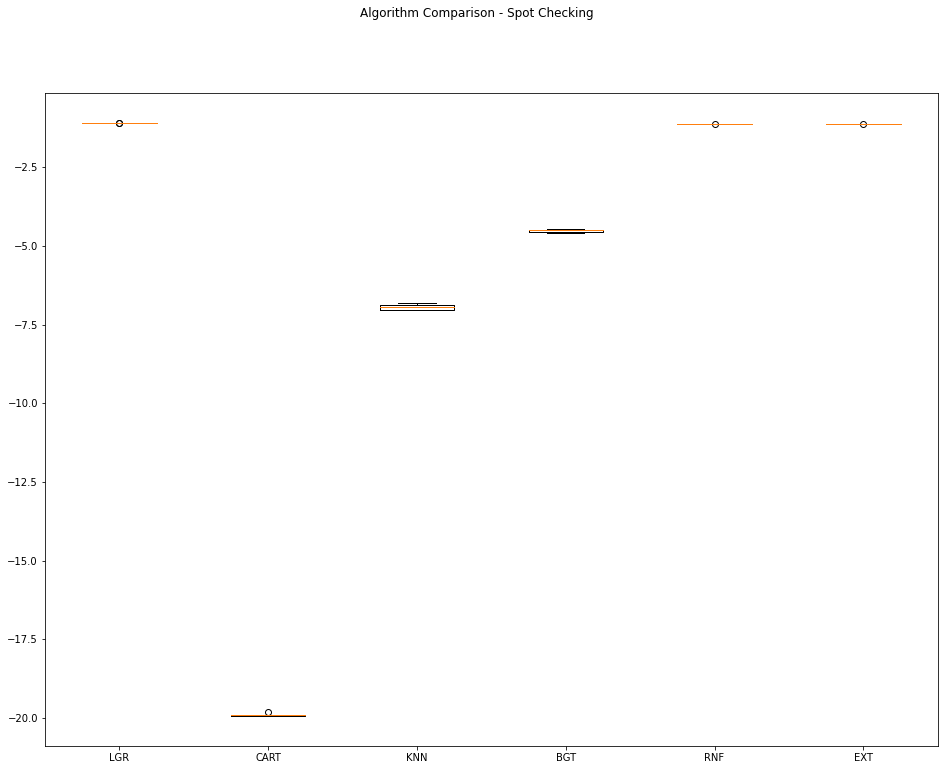

In [38]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Spot Checking')
ax = fig.add_subplot(111)
plt.boxplot(train_results)
ax.set_xticklabels(train_model_names)
plt.show()

In [39]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Evaluate Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Fine-tune and Improve Models

In [40]:
if NOTIFY_STATUS: status_notify("Task 5 - Fine-tune and Improve Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Algorithm Tuning

In [41]:
# Set up the comparison array
tune_results = []
tune_model_names = []

In [42]:
# Tuning algorithm #1 - Extra Trees
start_time_module = datetime.now()
if NOTIFY_STATUS: status_notify("Algorithm #1 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model1 = LogisticRegression(random_state=RNG_SEED, n_jobs=N_JOBS)
tune_model_names.append('LGR')
paramGrid1 = dict(C=np.array([1, 0.1, 0.01, 0.001]))

kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
grid1 = GridSearchCV(estimator=tune_model1, param_grid=paramGrid1, scoring=SCORING_METRIC, cv=kfold, n_jobs=N_JOBS, verbose=1)
grid_result1 = grid1.fit(array_features_train, array_target_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
tune_results.append(grid_result1.cv_results_['mean_test_score'])
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - start_time_module))
if NOTIFY_STATUS: status_notify("Algorithm #1 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best: -1.091886 using {'C': 0.01}
-1.096907 (0.001875) with: {'C': 1.0}
-1.095442 (0.002001) with: {'C': 0.1}
-1.091886 (0.001354) with: {'C': 0.01}
-1.093528 (0.001014) with: {'C': 0.001}
Model training time: 0:09:02.663940


In [43]:
best_paramKey1 = list(grid_result1.best_params_.keys())[0]
best_paramValue1 = list(grid_result1.best_params_.values())[0]
print("Captured the best parameter for algorithm #1:", best_paramKey1, '=', best_paramValue1)

Captured the best parameter for algorithm #1: C = 0.01


In [44]:
# Tuning algorithm #2 - Random Forest
start_time_module = datetime.now()
if NOTIFY_STATUS: status_notify("Algorithm #2 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model2 = RandomForestClassifier(random_state=RNG_SEED, n_jobs=N_JOBS)
tune_model_names.append('RNF')
paramGrid2 = dict(n_estimators=np.array([100, 250, 500, 750]))

kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
grid2 = GridSearchCV(estimator=tune_model2, param_grid=paramGrid2, scoring=SCORING_METRIC, cv=kfold, n_jobs=N_JOBS, verbose=1)
grid_result2 = grid2.fit(array_features_train, array_target_train)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
tune_results.append(grid_result2.cv_results_['mean_test_score'])
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - start_time_module))
if NOTIFY_STATUS: status_notify("Algorithm #2 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best: -1.106631 using {'n_estimators': 750}
-1.122255 (0.002469) with: {'n_estimators': 100}
-1.110667 (0.001200) with: {'n_estimators': 250}
-1.107802 (0.001136) with: {'n_estimators': 500}
-1.106631 (0.001133) with: {'n_estimators': 750}
Model training time: 1:33:33.516496


In [45]:
best_paramKey2 = list(grid_result2.best_params_.keys())[0]
best_paramValue2 = list(grid_result2.best_params_.values())[0]
print("Captured the best parameter for algorithm #2:", best_paramKey2, '=', best_paramValue2)

Captured the best parameter for algorithm #2: n_estimators = 750


### 5.b) Compare Algorithms After Tuning

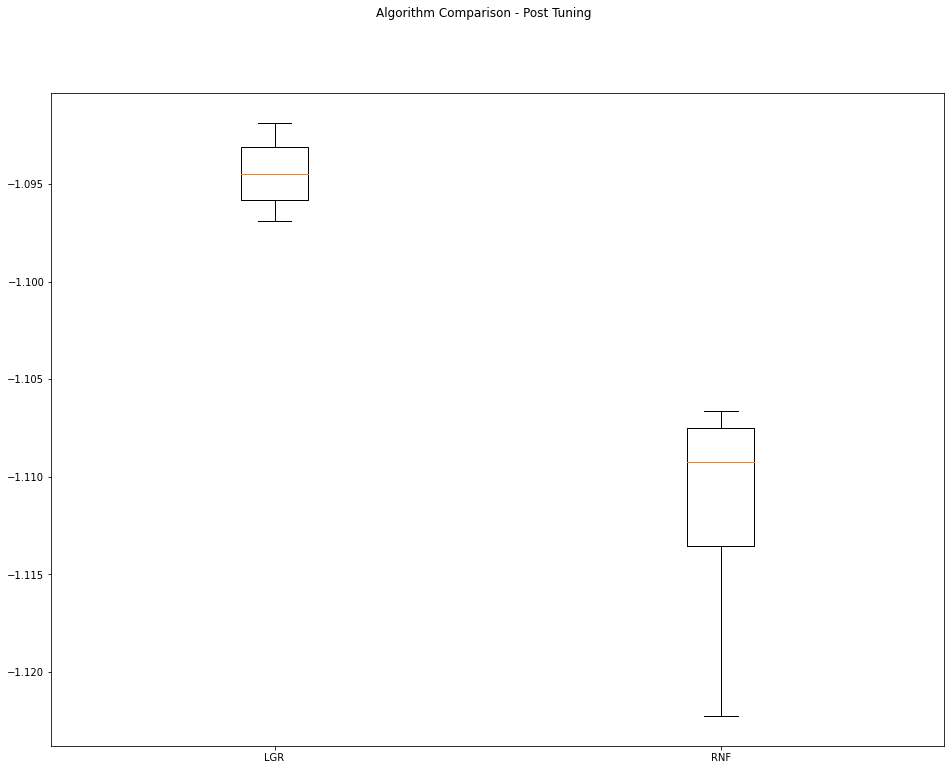

In [46]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
plt.boxplot(tune_results)
ax.set_xticklabels(tune_model_names)
plt.show()

In [47]:
if NOTIFY_STATUS: status_notify("Task 5 - Fine-tune and Improve Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 6 - Finalize Model and Present Analysis

In [48]:
if NOTIFY_STATUS: status_notify("Task 6 - Finalize Model and Present Analysis has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 6.a) Train the Final Model

In [49]:
final_model = LogisticRegression(C=best_paramValue1, random_state=RNG_SEED, n_jobs=N_JOBS)
final_model.fit(array_features_train, array_target_train)
print(final_model)

LogisticRegression(C=0.01, n_jobs=2, random_state=888)


### 6.b) Load Test Dataset and Prepare the Submission File

In [50]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021may/test.csv'
df_features_test = pd.read_csv(dataset_path, index_col=False)

# Take a peek at the dataframe after import
print(df_features_test.head())

       id  feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0  100000          0          0          0          0          0          0   
1  100001          0          0          1          0          0          0   
2  100002          0          0          0          0          0          0   
3  100003          0          0          0          0          0          0   
4  100004          0          0          0          0          0          0   

   feature_6  feature_7  feature_8  ...  feature_40  feature_41  feature_42  \
0          4          4          0  ...           0           0           0   
1          2          0          7  ...           3           0           1   
2          0          0          1  ...           0           0           0   
3          0          1          1  ...           0           0           0   
4          1          0          4  ...           1           0           0   

   feature_43  feature_44  feature_45  feature_46 

In [51]:
df_kaggle_submission = pd.DataFrame()
df_kaggle_submission['id'] = df_features_test['id']
print(df_kaggle_submission.head())

       id
0  100000
1  100001
2  100002
3  100003
4  100004


In [52]:
# Dropping features
df_features_test.drop(columns=['id'], inplace=True)

# Convert columns from one data type to another
test_feature_list = list(df_features_test.columns)
for feature in test_feature_list:
    df_features_test[feature] = df_features_test[feature].astype('category')

# Take a peek at the dataframe after cleaning
print(df_features_test.head())

  feature_0 feature_1 feature_2 feature_3 feature_4 feature_5 feature_6  \
0         0         0         0         0         0         0         4   
1         0         0         1         0         0         0         2   
2         0         0         0         0         0         0         0   
3         0         0         0         0         0         0         0   
4         0         0         0         0         0         0         1   

  feature_7 feature_8 feature_9  ... feature_40 feature_41 feature_42  \
0         4         0         0  ...          0          0          0   
1         0         7         7  ...          3          0          1   
2         0         1         0  ...          0          0          0   
3         1         1         0  ...          0          0          0   
4         0         4         0  ...          1          0          0   

  feature_43 feature_44 feature_45 feature_46 feature_47 feature_48 feature_49  
0          0          0      

In [53]:
# Finalize the test dataset for the modeling testing
array_features_test = preprocessor.transform(df_features_test)
print("Transformed features from df_features_test.shape: {} to array_features_test.shape: {}".format(df_features_test.shape, array_features_test.shape))

Transformed features from df_features_test.shape: (50000, 50) to array_features_test.shape: (50000, 1355)


In [54]:
# Make batched predictions
test_predictions = final_model.predict_proba(array_features_test)
print(test_predictions)

[[0.10324851 0.62640254 0.13790613 0.13244282]
 [0.07509937 0.69742662 0.12039295 0.10708107]
 [0.0811926  0.66329158 0.16547951 0.0900363 ]
 ...
 [0.07393568 0.51379413 0.24377657 0.16849362]
 [0.08652165 0.60897416 0.16491321 0.13959098]
 [0.09417708 0.57148465 0.21567929 0.11865898]]


In [55]:
df_kaggle_submission[['Class_1','Class_2','Class_3','Class_4']] = test_predictions
print(df_kaggle_submission.head())

       id   Class_1   Class_2   Class_3   Class_4
0  100000  0.103249  0.626403  0.137906  0.132443
1  100001  0.075099  0.697427  0.120393  0.107081
2  100002  0.081193  0.663292  0.165480  0.090036
3  100003  0.083770  0.536348  0.299975  0.079906
4  100004  0.077976  0.645498  0.172500  0.104026


In [56]:
submission_file = df_kaggle_submission.to_csv(header=True, index=False)
filename = 'submission_' + datetime.now().strftime('%Y%m%d-%H%M') + '.csv'
with open(filename, 'w') as f:
    f.write(submission_file)
    print('Completed writing output file: ' + filename)

Completed writing output file: submission_20210707-0245.csv


In [57]:
if NOTIFY_STATUS: status_notify("Task 6 - Finalize Model and Present Analysis completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [58]:
print ('Total time for the script:',(datetime.now() - start_time_script))

Total time for the script: 2:20:36.813102
